# Kubeflow Pipelines Creation using Kale

## Install dependencies

In [14]:
!wget -q https://raw.githubusercontent.com/kubeflow-kale/examples/master/titanic-ml-dataset/requirements.txt
!pip3 install -r requirements.txt --user -q    

/home/jovyan
You should consider upgrading via the 'pip install --upgrade pip' command.


**Important:** Restart this Kernel after the installation is completed. 

## Similate Data Ingestion

In [5]:
!wget -q https://raw.githubusercontent.com/kubeflow-kale/examples/master/titanic-ml-dataset/data/train.csv -O data/train.csv 
!wget -q https://raw.githubusercontent.com/kubeflow-kale/examples/master/titanic-ml-dataset/data/test.csv -O data/test.csv

## Dataset: Titanic passengers survival prediction

This Notebook will use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. The dataset provides information on the fate of passengers on the Titanic, summarized according to economic status (class), sex, age and survival.

Credit for this Notebook goes to Niklas Donges, who published a very detailed post [here](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8). Check it out if you want to dive deeper in the data analysis and machine learning details of the challenge.

#### Import dependencies and load data

In [8]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

print('numpy:', np.__version__)
print('pandas:', pd.__version__)

numpy: 1.16.4
pandas: 0.25.1


In [12]:
dataset_path = "data/"

PREDICTION_LABEL = 'Survived'

test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv'))
train_df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))

#### Let's explore the data

These are features of the dataset:

| Feature | Description   |
|------|------|
| survival | Survival | 
| PassengerId | Unique Id of a passenger | 
| pclass | Ticket class |     
| sex | Sex |     
| Age | Age in years |     
| sibsp | # of siblings / spouses aboard the Titanic |     
| parch | # of parents / children aboard the Titanic |    
| ticket | Ticket number |    
| fare | Passenger fare |    
| cabin | Cabin number |    
| embarked | Port of Embarkation |


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Missing data**

Let's see here how much data is missing. We will have to fill the missing features later on.

In [17]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


**Age and Sex**

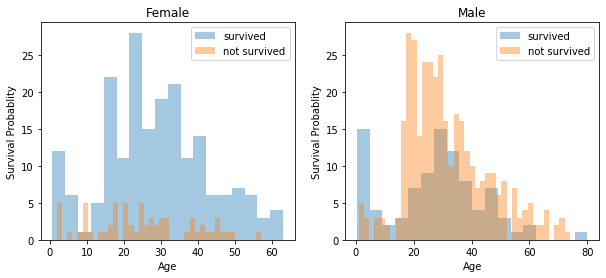

In [18]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax.set_ylabel('Survival Probablity')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male')
_ = ax.set_ylabel('Survival Probablity')

**Embarked, Pclass and Sex**

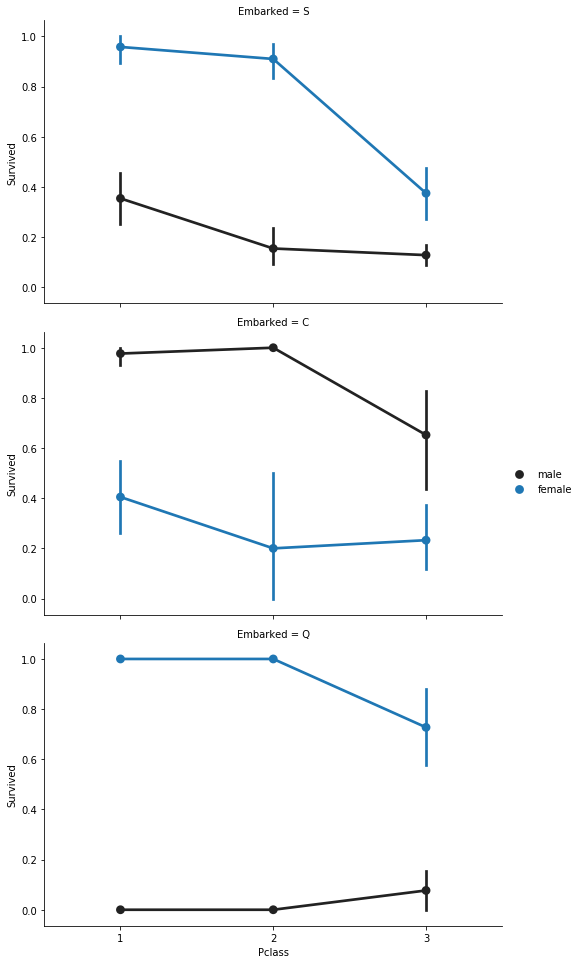

In [19]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
_ = FacetGrid.add_legend()

**Pclass**

Explore if `Pclass` is contributing to a person chance of survival 

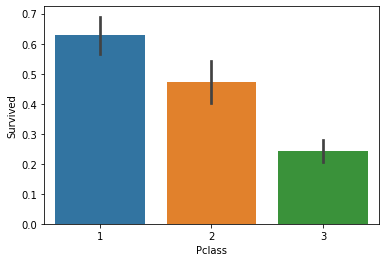

In [20]:
_ = sns.barplot(x='Pclass', y='Survived', data=train_df)

Here we confirm that being in class 1 increases the chances of survival, and that a person in class 3 has high chances of not surviving

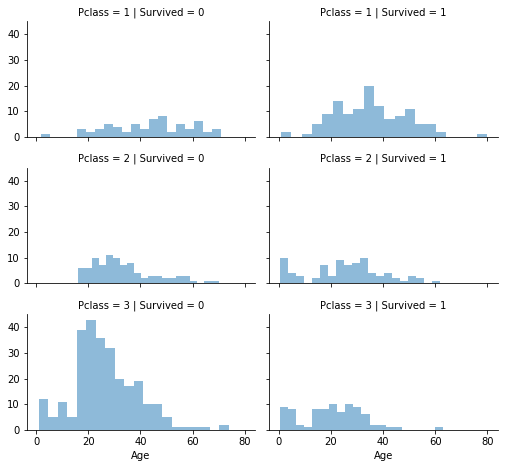

In [21]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## DATA PROCESSING

#### SibSp and Parch

Combine these two features as the number of relatives

In [22]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

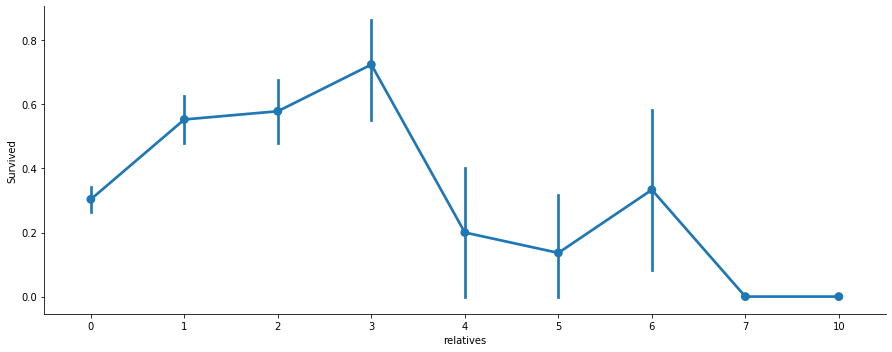

In [23]:
# Survival with respect to the number of relatives in the ship
axes = sns.catplot('relatives','Survived', kind='point',
                      data=train_df, aspect = 2.5, )

In [24]:
# This does not contribute to a person survival probability
train_df = train_df.drop(['PassengerId'], axis=1)

#### Missing data: Cabin

Create a new `Deck` feature

In [25]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

#### Missing data: Age

Fill missing data from age feature with a random sampling from the distribution of the existing values.

In [26]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

#### Missing data: Embarked

In [27]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [28]:
# fill with most common value
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

#### Convert Features

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          891 non-null int64
SibSp        891 non-null int64
Parch        891 non-null int64
Ticket       891 non-null object
Fare         891 non-null float64
Embarked     891 non-null object
relatives    891 non-null int64
not_alone    891 non-null int64
Deck         891 non-null int64
dtypes: float64(1), int64(8), object(4)
memory usage: 90.6+ KB


In [30]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

#### Titles features

In [31]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

#### Sex into numeric

In [32]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

#### Drop Ticket feature

In [33]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

#### Embarked into numeric

In [34]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

#### Age into categories

In [35]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed train_df['Age'].value_counts()

#### Fare into categories

In [36]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

## New Features

#### Age times Class

In [37]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

#### Fare per person

In [38]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,1,0,0,1,8,1,15,1
5,0,3,0,5,0,0,1,2,0,1,8,1,15,1
6,0,1,0,6,0,0,3,0,0,1,5,1,6,3
7,0,3,0,0,3,1,2,0,4,0,8,4,0,0
8,1,3,1,3,0,2,1,0,2,0,8,3,9,0
9,1,2,1,1,1,0,2,1,1,0,8,3,2,1


## ML

Because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other

In [39]:
train_labels = train_df[PREDICTION_LABEL]



#### Random Forest

In [40]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_df, train_labels)
acc_random_forest = round(random_forest.score(train_df, train_labels) * 100, 2)

#### Logistic Regression

In [41]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(train_df, train_labels)
acc_log = round(logreg.score(train_df, train_labels) * 100, 2)

#### Gaussian Naive Bayes

In [42]:
gaussian = GaussianNB()
gaussian.fit(train_df, train_labels)
acc_gaussian = round(gaussian.score(train_df, train_labels) * 100, 2)

#### Linear SVM

In [43]:
linear_svc = LinearSVC()
linear_svc.fit(train_df, train_labels)
acc_linear_svc = round(linear_svc.score(train_df, train_labels) * 100, 2)

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Decision Tree

In [44]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_df, train_labels)
acc_decision_tree = round(decision_tree.score(train_df, train_labels) * 100, 2)

## Results

In [45]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Decision Tree'],
    'Score': [acc_linear_svc, acc_log, 
              acc_random_forest, acc_gaussian, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
print(result_df)

                         Model
Score                         
100.0  Support Vector Machines
100.0      logistic Regression
100.0            Random Forest
100.0              Naive Bayes
100.0            Decision Tree
